In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.dummy import DummyRegressor
from sklearn import linear_model, ensemble
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('df_preprocessed.pickle', 'rb') as fp:
    df = pickle.load(fp)
df

,Datum,Wochentag,Fahrweg,Fahrt,Fahrzeugnummer,Linienverlauf,SollAb,IstAb,GPS-Breite Soll,GPS-Länge Soll,...,Linienverlauf_51 Hansestr. A,Linienverlauf_52 Raringheide,Linienverlauf_53 Pater-Kolbe-Str.,Linienverlauf_54 Plutoweg,Linienverlauf_55 Amelsb¿ren Schule,Linienverlauf_56 Amelsb¿ren Kirche,Linienverlauf_57 Davertstr. B,Linienverlauf_58 Am Dornbusch,Haltestelle,month
0,2016-10-10,Montag,4,1061896,1299,01 Roxel Hallenbad A,2016-10-10 05:16:00,2016-10-10 05:15:45,519544255.0,75273611.0,...,0,0,0,0,0,0,0,0,1,10
1,2016-10-10,Montag,2,1081890,5556,30 Ludgeriplatz B,2016-10-10 05:17:00,2016-10-10 05:17:58,519558997.0,76278508.0,...,0,0,0,0,0,0,0,0,30,10
2,2016-10-10,Montag,4,1061896,1299,03 Pienersallee,2016-10-10 05:19:00,2016-10-10 05:19:09,519511969.0,75300852.0,...,0,0,0,0,0,0,0,0,3,10
3,2016-10-10,Montag,2,1081890,5556,31 Goebenstr.,2016-10-10 05:19:00,2016-10-10 05:19:03,51952888.0,76254844.0,...,0,0,0,0,0,0,0,0,31,10
4,2016-10-10,Montag,4,1061896,1299,04 Stellmacherweg,2016-10-10 05:20:00,2016-10-10 05:20:16,519486219.0,75275802.0,...,0,0,0,0,0,0,0,0,4,10
5,2016-10-10,Montag,2,1081890,5556,32 St. Joseph-Kirche,2016-10-10 05:20:00,2016-10-10 05:20:00,519493516.0,76243561.0,...,0,0,0,0,0,0,0,0,32,10
6,2016-10-10,Montag,2,1081890,5556,33 Alter Sch¿tzenhof A,2016-10-10 05:21:00,2016-10-10 05:20:44,519460313.0,76232794.0,...,0,0,0,0,0,0,0,0,33,10
7,2016-10-10,Montag,4,1061896,1299,05 Roxel Bahnhof,2016-10-10 05:21:00,2016-10-10 05:21:13,519462505.0,75262616.0,...,0,0,0,0,0,0,0,0,5,10
8,2016-10-10,Montag,4,1061896,1299,06 Stellmacherweg,2016-10-10 05:22:00,2016-10-10 05:22:34,519485516.0,75277136.0,...,0,0,0,0,0,0,0,0,6,10
9,2016-10-10,Montag,2,1081890,5556,34 Metzer Str.,2016-10-10 05:23:00,2016-10-10 05:23:20,519422225.0,76234541.0,...,0,0,0,0,0,0,0,0,34,10


## Take a look at the preprocessed data

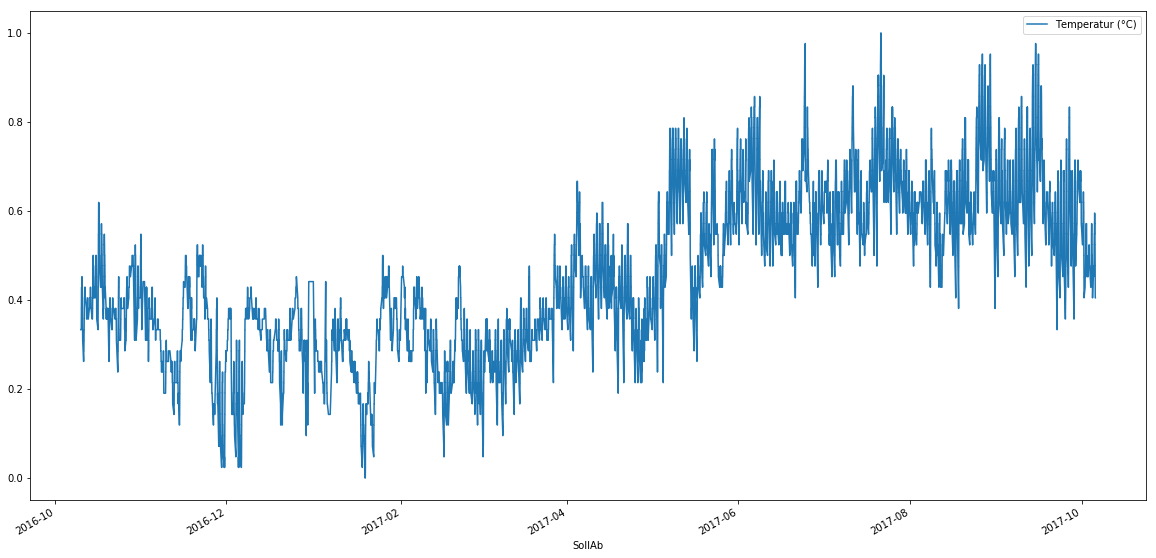

In [175]:
df.plot(x='SollAb', y='Temperatur (°C)', figsize=(20, 10))

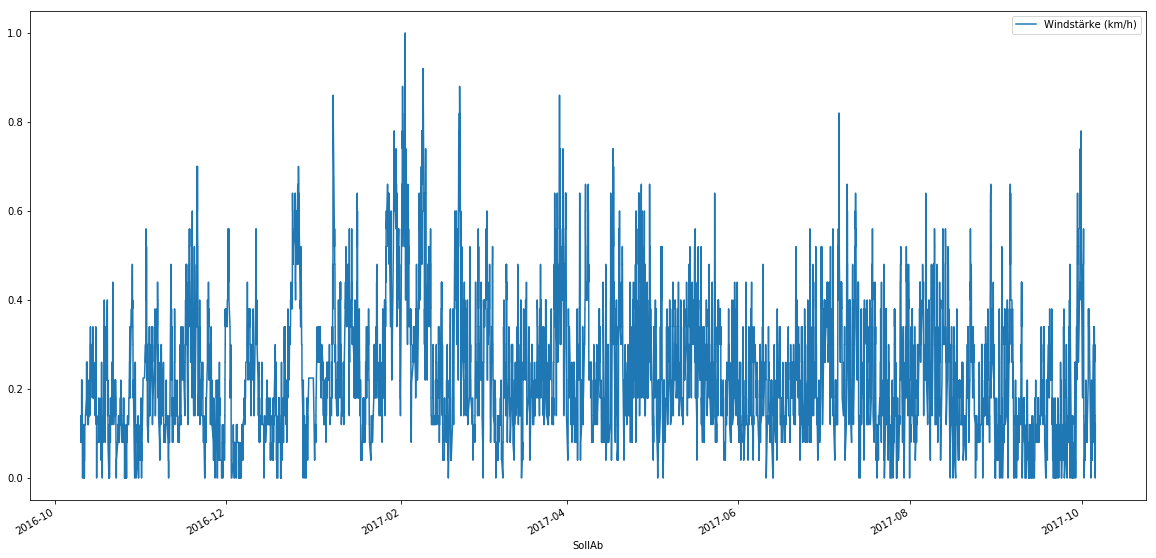

In [176]:
df.plot(x='SollAb', y='Windstärke (km/h)', figsize=(20, 10))

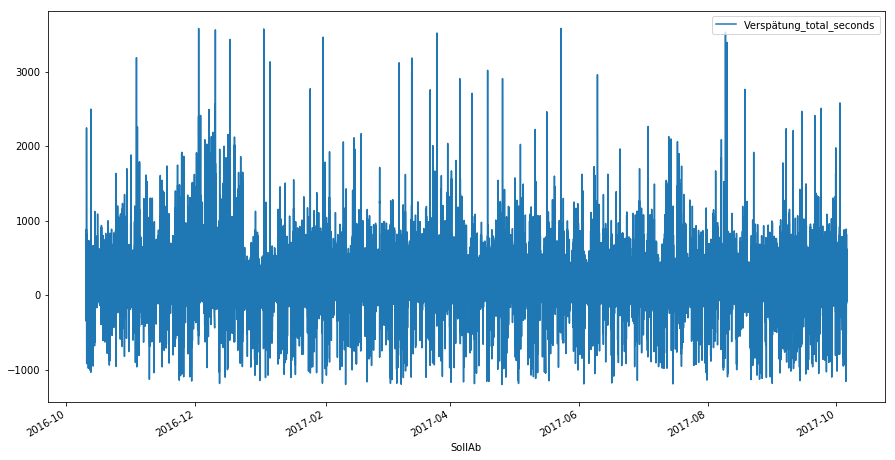

In [177]:
df.plot(x='SollAb', y='Verspätung_total_seconds', figsize=(15, 8))

In [55]:
# Exclude single drives to test on for later.
df_one_drive1 = df[(df["Datum"] == "2017-03-10") & (df["Fahrt"] == 1022034)]
df_one_drive2 = df[(df["Datum"] == "2017-07-21") & (df["Fahrt"] == 1223066)]
df_one_drive3 = df[(df["Datum"]=="2016-11-27") & (df_one_day["Fahrt"]==1367074)]

In [58]:
# Split into training and test set (1:10).
df_test = df.iloc[::10]
df_train = df.iloc[~df.index.isin(df_test.index)]
# Remove drives from training set.
df_train = df_train.iloc[~(df_train.index.isin(df_one_drive1.index)
                          ^ df_train.index.isin(df_one_drive2.index)
                          ^ df_train.index.isin(df_one_drive3.index))]
df_train.shape, df_test.shape

((740077, 92), (82248, 92))

In [59]:
# Separate data into features and target.
feature_cols = [col_name for col_name in df 
                if col_name.startswith('Wetter_') 
                or col_name.startswith('Wochentag_')
                or col_name.startswith('Linienverlauf_')]
feature_cols.extend(['Temperatur (°C)', 'Windstärke (km/h)', 'Feiertag', 'month', 'Haltestelle'])
features = df_train[feature_cols]
target = df_train['Verspätung_total_seconds']

In [60]:
df_train[feature_cols]

,Wochentag_Dienstag,Wochentag_Donnerstag,Wochentag_Freitag,Wochentag_Mittwoch,Wochentag_Montag,Wochentag_Samstag,Wochentag_Sonntag,Wetter_Gewitter,Wetter_Klarer Himmel,Wetter_Nebel,...,Linienverlauf_54 Plutoweg,Linienverlauf_55 Amelsb¿ren Schule,Linienverlauf_56 Amelsb¿ren Kirche,Linienverlauf_57 Davertstr. B,Linienverlauf_58 Am Dornbusch,Temperatur (°C),Windstärke (km/h),Feiertag,month,Haltestelle
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,30
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,3
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,31
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,4
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,32
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,33
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,5
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,6
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,34
11,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,35


## Try out different models

In [62]:
def try_model(model):
    model.fit(features, target)
    predictions = model.predict(df_test[feature_cols])
    loss = np.mean(np.abs((df_test['Verspätung_total_seconds'] - predictions)))
    print('loss = ', loss)
    return model

In [63]:
mdummy = try_model(DummyRegressor())

loss =  140.624616496


In [64]:
m0 = try_model(linear_model.LinearRegression())

loss =  127.331987051


In [111]:
#m1 = try_model(linear_model.ElasticNetCV())

In [112]:
#m2 = try_model(linear_model.ElasticNet())

In [113]:
#m3 = try_model(ensemble.RandomForestRegressor())

In [65]:
m4 = try_model(ensemble.RandomForestRegressor(n_estimators=20))

loss =  116.561062709


## Plot the results


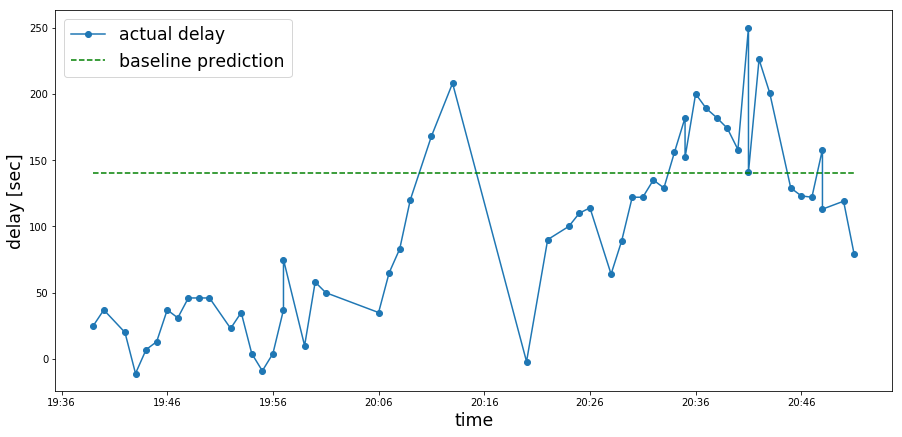

In [171]:
%matplotlib inline
import matplotlib.dates as md


def plot_comparison(model, drive, label, format_str):
    # Predict the reserved drive.
    prediction = model.predict(drive[feature_cols])
    plt.figure(figsize=(15, 7))
    plt.plot(drive["SollAb"], drive['Verspätung_total_seconds'], '-o',label="actual delay")
    plt.plot(drive["SollAb"], prediction, format_str,label=label + ' prediction')
    xfmt = md.DateFormatter('%H:%M')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(xfmt)
    plt.xlabel('time', fontsize='xx-large')
    plt.ylabel('delay [sec]', fontsize='xx-large')
    plt.legend(loc='upper left', fontsize='xx-large')
    plt.savefig(label + '.png', dpi=600)

plot_comparison(mdummy, df_one_drive3, 'baseline', 'g--')

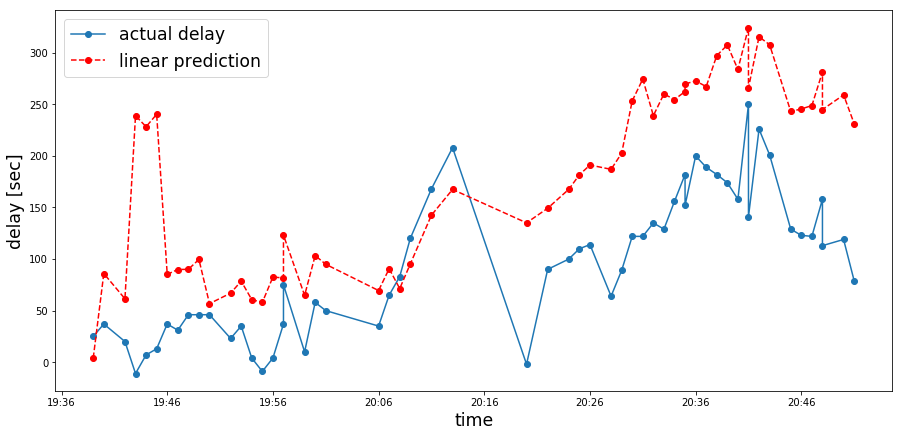

In [173]:
plot_comparison(m0, df_one_drive3, 'linear', 'ro--')

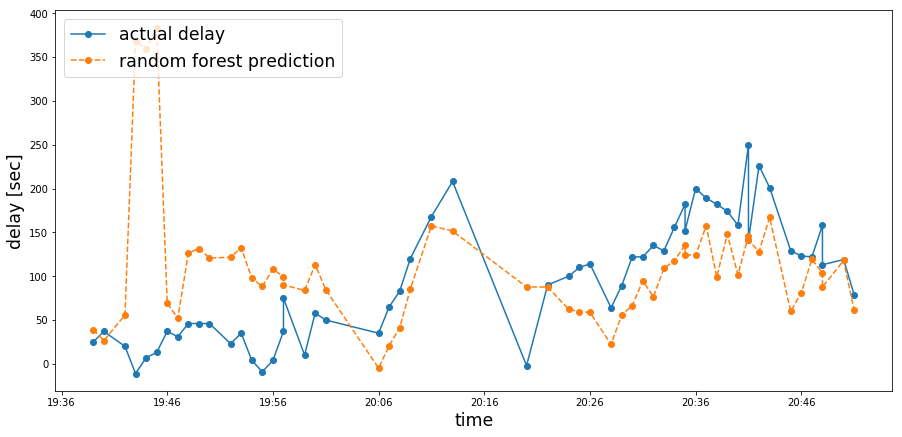

In [174]:
plot_comparison(m4, df_one_drive3, 'random forest', 'o--')